##  **Model 1: GloVe (Global Vectors for Word Representation)**
We have decided to test two models and use the model with the better accuracy for our project.We choose GloVe as one of the models  as using GloVe helps:

*   Deal with short, slang-filled tweets more effectively
*   Understand word relationships and sentiment better

*   Leverage pre-trained knowledge without needing millions of examples

GloVe is an unsupervised learning algorithm that generates vector representations for words, also known as word embeddings.






In [16]:
!pip install preprocessor
!pip install tensorflow


In [68]:
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import numpy as np
from tensorflow.keras.layers import Embedding, SimpleRNN,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
election = pd.read_csv('/content/election.csv')
election.head()

,id,clean_text,polarity,place
0,1.11772E+18,RT chitraSD Jogging RahulGandhi ’ memory famil...,0,Madras
1,1118061974292533249,AAP INC want alliance stop division Anti-Modi ...,0,NaN
2,1117870131969810432,RT pankaj_shankar She priyankagandhi slams Mod...,0,NaN
3,1.1177E+18,RT airnewsalerts SC says RahulGandhi 's remark...,0,New Delhi
4,1117850484327366656,RT sachinsingh1010 75 year old Govindraj kille...,0,New Delhi Varanasi


We need to perform further cleaning as there more unwanted elements in the text as you can see above like the Phrase RT and so.

In [19]:
def tweet_to_words( raw_review ):

    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', letters_only) # remove URLs
    tweet = re.sub('RT', ' ', str(tweet))

    #Convert to lower case, split into individual words
    tweet = letters_only.lower().split()

    return( " ".join(tweet))

In [20]:
election['id'].count()

np.int64(10365)

In [21]:
num_tweets = 10365
clean_train_tweets = []


for i in range( 0, num_tweets ):
    # Call function for each one, and add the result to the list of clean reviews
    clean_train_tweets.append( tweet_to_words( election["clean_text"][i] ) )

In [22]:
data_inputs =  clean_train_tweets
data_labels = list(election.polarity)

In [23]:
tokenizer = Tokenizer(nb_words=2000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 8213 unique tokens.
Shape of data tensor: (10365, 1000)
Shape of label tensor: (10365, 2)


**SPLITTING THE DATA INTO TRAING ANG TESTING DATA IN 80:20 RATIO**


In [24]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

**USING THE PRETRAINED MODEL : GloVe TO CREATE WORD EMBEDDING MATRIX**

In [26]:
embeddings_index = {}
f = open( r"/content/glove.6B.100d.txt", encoding ="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 239099 word vectors.


In [37]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)

### **CREATING THE MODEL**

(CREDIT:ABISHIEK CITDED IN REFERENCE)

In [44]:
def model_creation():
    input_layer = Input(shape=(1000,), dtype='int32')
    embed_layer = embedding_layer(input_layer)
    x = Dense(100, activation='relu')(embed_layer)
    x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
    x = Flatten()(x)
    x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002))(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_layer = Dense(1, activation='sigmoid')(x)

    opt = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model = Model(input_layer, final_layer)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


In [47]:
learning_rate = 0.0001
batch_size = 1024
epochs = 10
y_train_binary = np.argmax(y_train, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

model_glove = model_creation()
model_final = model_glove.fit(x_train, y_train_binary, validation_data=(x_val, y_val_binary),epochs=epochs, batch_size=batch_size)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.5308 - loss: 1.0158 - val_accuracy: 0.7062 - val_loss: 0.9745
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.6213 - loss: 0.9647 - val_accuracy: 0.7221 - val_loss: 0.9268
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6548 - loss: 0.9192 - val_accuracy: 0.7168 - val_loss: 0.8828
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6616 - loss: 0.8792 - val_accuracy: 0.7516 - val_loss: 0.8417
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6779 - loss: 0.8408 - val_accuracy: 0.7651 - val_loss: 0.8048
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7137 - loss: 0.8033 - val_accuracy: 0.7699 - val_loss: 0.7676
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7134 - loss: 0.7723 - val_accuracy: 0.7699 - val_loss: 0.7321
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7253 - loss: 0.7448 - val_accuracy: 0.7795 - val_loss: 0.7017
Epoch 9/

### **Training the model further....**

In [48]:
model_final = model_glove.fit(x_train, y_train_binary, validation_data=(x_val, y_val_binary),epochs=100, batch_size=batch_size)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.7745 - loss: 0.6511 - val_accuracy: 0.8080 - val_loss: 0.6163
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7834 - loss: 0.6335 - val_accuracy: 0.7993 - val_loss: 0.5948
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7914 - loss: 0.6133 - val_accuracy: 0.8152 - val_loss: 0.5733
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8026 - loss: 0.5889 - val_accuracy: 0.8201 - val_loss: 0.5557
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8138 - loss: 0.5714 - val_accuracy: 0.8263 - val_loss: 0.5413
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8330 - loss: 0.5545 - val_accuracy: 0.8321 - val_loss: 0.5249
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8330 - loss: 0.5460 - val_accuracy: 0.8326 - val_loss: 0.5106
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8307 - loss: 0.5307 - val_accuracy: 0.8408 - val_loss: 0.4991


In [49]:
model_final1 = model_glove.fit(x_train,y_train_binary, validation_data=(x_val, y_val_binary),epochs=20, batch_size=batch_size)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9753 - loss: 0.1865 - val_accuracy: 0.9551 - val_loss: 0.2264
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9751 - loss: 0.1823 - val_accuracy: 0.9561 - val_loss: 0.2275
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9771 - loss: 0.1801 - val_accuracy: 0.9571 - val_loss: 0.2253
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9783 - loss: 0.1823 - val_accuracy: 0.9571 - val_loss: 0.2239
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9752 - loss: 0.1831 - val_accuracy: 0.9585 - val_loss: 0.2234
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9742 - loss: 0.1843 - val_accuracy: 0.9556 - val_loss: 0.2240
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9761 - loss: 0.1778 - val_accuracy: 0.9595 - val_loss: 0.2207
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9751 - loss: 0.1810 - val_accuracy: 0.9590 - val_loss: 0.2204
Epoch 9/

### **SAVING THE MODEL AND THE WEIGHTS**

In [53]:
#create directory
import os
os.makedirs("./SavedModels", exist_ok=True)


# Save model architecture
model_json = model_glove.to_json()
with open("./SavedModels/Model_glove.json", "w") as json_file:  # use .json for architecture
    json_file.write(model_json)

# Save weights (must end with `.weights.h5`)
model_glove.save_weights("./SavedModels/Weights_glove.weights.h5")
print("Saved model to disk")


Saved model to disk


### **CALCULATE THE MODEL LOSS AND ACCURACY**

In [55]:
loss,acc = model_glove.evaluate(x_val,y_val_binary, verbose = 2, batch_size = batch_size)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc))

3/3 - 3s - 1s/step - accuracy: 0.9629 - loss: 0.2120
Validation Loss: 0.21
Validation Accuracy: 0.96


### **PLOTTING THE MODEL PERFORMANCE METRICS**

In [64]:
def plot_modelacc(fit_model):
    with plt.style.context('ggplot'):
        plt.plot(fit_model.history['accuracy'])
        plt.plot(fit_model.history['val_accuracy'])
        plt.ylim(0, 1)
        plt.title("MODEL ACCURACY")
        plt.xlabel("# of EPOCHS")
        plt.ylabel("ACCURACY")
        plt.legend(['train', 'test'], loc='upper left')
    return plt.show()


In [63]:
def plot_model_loss(fit_model):
    with plt.style.context('ggplot'):
            plt.plot(fit_model.history['loss'])
            plt.plot(fit_model.history['val_loss'])
            plt.title("MODEL LOSS")
            plt.xlabel("# of EPOCHS")
            plt.ylabel("LOSS")
            plt.legend(['train', 'test'], loc='upper left')
    return plt.show()

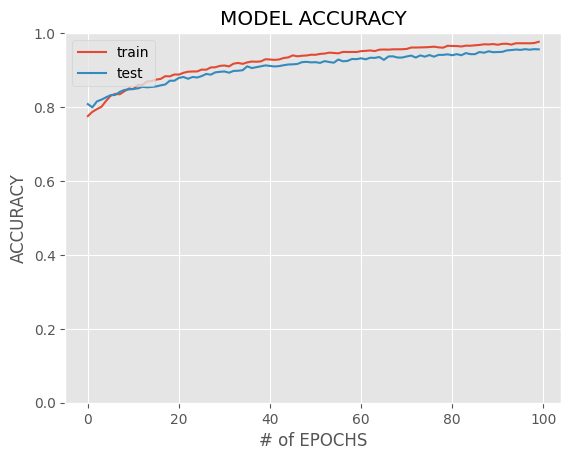

In [65]:
plot_modelacc(model_final)

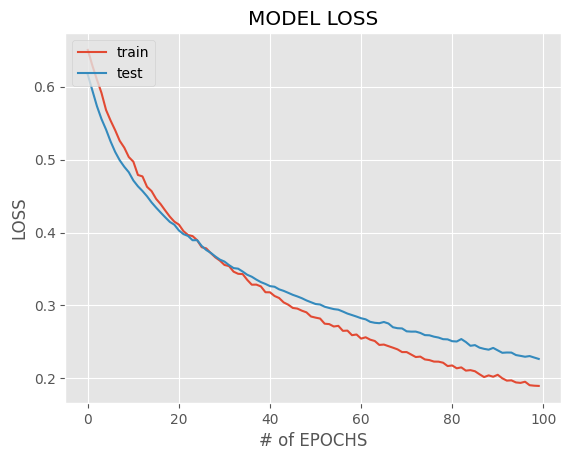

In [60]:
plot_model_loss(model_final)

### **CONFUSION MATRIX**

A CONFUSION MATRIX CAN BE USED TO DEPICT THE VALUES THAT THE MODEL HAS PREDICTED AND COMPARE WITH IT THE ACTUAL RESULTS TO REACH A CONCLUSION ABOUT THE ACCURACY OF THE MODEL.

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


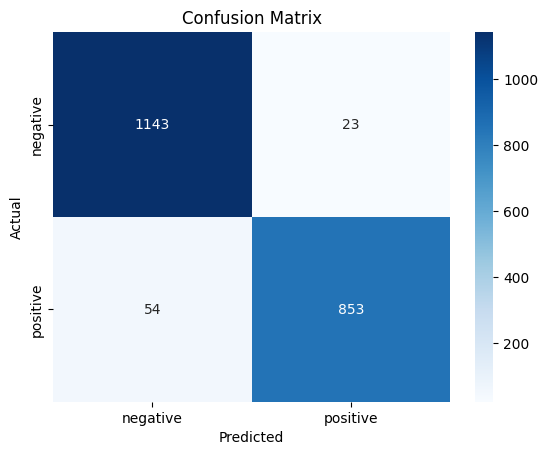

In [69]:
y_pred = model_glove.predict(x_val)

# Apply 0.5 threshold
y_pred = (y_pred > 0.5).astype(int)

# Convert one-hot encoded y_val to labels
y_val_labels = y_val.argmax(axis=1)

# Flatten y_pred to 1D
y_pred_labels = y_pred.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Plot
LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


True Positives: 853 (Predicted True and True in reality)<br>
True Negative: 1143(Predicted False and False in realtity)<br>
False Positive: 23 (Predicted Positve but Negative in reality)<br>
False Negative: 54 (Predicted Negative but Positive in reality)